# 02 — Baseline MMM

## Objective
Build a baseline Marketing Mix Model using weekly aggregated data
and paid media spend as inputs.

## Inputs
- Selected single time series from `01_data_audit_eda.ipynb`
- Daily marketing spend and purchase data

## Output
- Baseline linear MMM
- Initial interpretation of channel coefficients


In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression


In [2]:
target_col = "ALL_PURCHASES"
date_col = "DATE_DAY"

## Context — Weekly aggregation

MMM is typically modeled at weekly frequency to reduce noise and improve stability.
In this step, daily data is aggregated to weekly level.


In [3]:
df_one = pd.read_csv("../data/processed/mmm_dataset.csv")

df_one[date_col] = pd.to_datetime(df_one[date_col], errors="coerce")
df_one["week"] = df_one[date_col].dt.to_period("W").dt.start_time

spend_cols = [c for c in df_one.columns if c.endswith("_SPEND")]

df_weekly = (
    df_one
    .groupby("week", as_index=False)
    .agg(
        {**{c: "sum" for c in spend_cols},
         target_col: "sum"}
    )
)

df_weekly.head()


,week,GOOGLE_PAID_SEARCH_SPEND,GOOGLE_SHOPPING_SPEND,GOOGLE_PMAX_SPEND,GOOGLE_DISPLAY_SPEND,GOOGLE_VIDEO_SPEND,META_FACEBOOK_SPEND,META_INSTAGRAM_SPEND,META_OTHER_SPEND,TIKTOK_SPEND,ALL_PURCHASES
0,2019-08-12,318.31,142.83,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32
1,2019-08-19,660.70,296.81,0.0,0.0,0.0,0.0,0.0,0.0,0.0,96
2,2019-08-26,934.22,283.20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,91
3,2019-09-02,826.32,324.91,0.0,0.0,0.0,0.0,0.0,0.0,0.0,82
4,2019-09-09,906.49,321.42,0.0,0.0,0.0,0.0,0.0,0.0,0.0,105


## Decision
Aggregate daily data to weekly frequency using sum aggregation.

## Rationale
- Spend and purchases are additive over time.
- Weekly aggregation reduces noise and channel sparsity.
- This aligns with standard MMM practice.


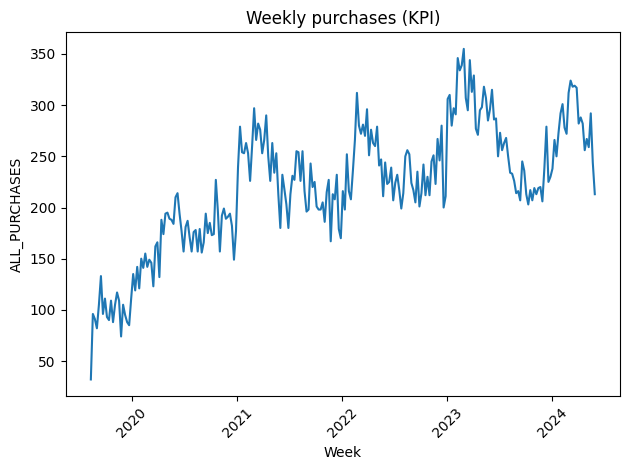

In [4]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(df_weekly["week"], df_weekly[target_col])
plt.title("Weekly purchases (KPI)")
plt.xlabel("Week")
plt.ylabel(target_col)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [5]:
df_weekly[spend_cols] = df_weekly[spend_cols].fillna(0)

df_weekly.isna().sum().sort_values(ascending=False)


week                        0
GOOGLE_PAID_SEARCH_SPEND    0
GOOGLE_SHOPPING_SPEND       0
GOOGLE_PMAX_SPEND           0
GOOGLE_DISPLAY_SPEND        0
GOOGLE_VIDEO_SPEND          0
META_FACEBOOK_SPEND         0
META_INSTAGRAM_SPEND        0
META_OTHER_SPEND            0
TIKTOK_SPEND                0
ALL_PURCHASES               0
dtype: int64

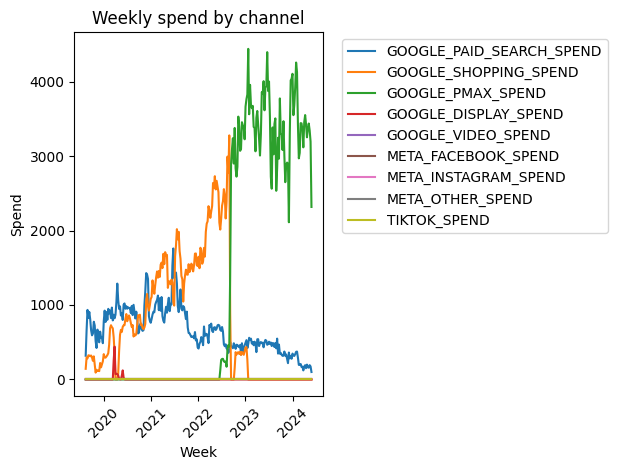

In [6]:
plt.figure()
for col in spend_cols:
    plt.plot(df_weekly["week"], df_weekly[col], label=col)

plt.title("Weekly spend by channel")
plt.xlabel("Week")
plt.ylabel("Spend")
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


## Train linear baseline MMM
### Context
As a first step, we fit a simple linear model that relates weekly marketing spend
to weekly purchases. This model does not account for carryover effects,
diminishing returns, or interactions between channels.


In [7]:

X = df_weekly[spend_cols]
y = df_weekly[target_col]

model = LinearRegression()
model.fit(X, y)

coefs = (
    pd.Series(model.coef_, index=spend_cols)
    .sort_values(ascending=False)
)

coefs


GOOGLE_SHOPPING_SPEND       0.056580
GOOGLE_PAID_SEARCH_SPEND    0.053828
GOOGLE_PMAX_SPEND           0.045969
GOOGLE_DISPLAY_SPEND        0.022894
GOOGLE_VIDEO_SPEND          0.000000
META_FACEBOOK_SPEND         0.000000
META_INSTAGRAM_SPEND        0.000000
META_OTHER_SPEND            0.000000
TIKTOK_SPEND                0.000000
dtype: float64

In [8]:
intercept = model.intercept_
intercept


np.float64(83.66514706203083)

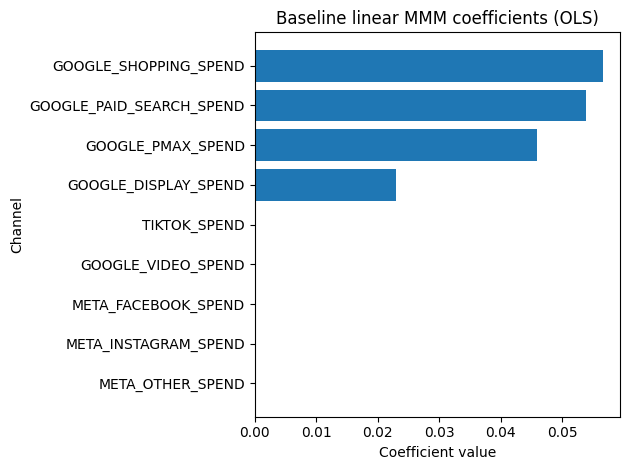

In [9]:
coefs_sorted = coefs.sort_values()

plt.figure()
plt.barh(coefs_sorted.index, coefs_sorted.values)
plt.title("Baseline linear MMM coefficients (OLS)")
plt.xlabel("Coefficient value")
plt.ylabel("Channel")
plt.tight_layout()
plt.show()


This baseline model estimates linear associations between weekly marketing spend and weekly purchases. Coefficients should not be interpreted as incremental or causal effects, as the model does not include carryover, saturation, or control variables.

The dominance of Search-related channels suggests that the model is primarily capturing existing demand rather than demand creation. The near-zero coefficients for upper-funnel channels are consistent with a model that ignores delayed effects, highlighting the need for adstock modeling in the next phase.

The relatively high intercept represents baseline demand and non-modeled drivers of purchases, which is expected in a baseline MMM.

### Decision
Use an ordinary least squares linear regression as the baseline MMM.
### Rationale
A linear model provides a transparent and interpretable baseline that
highlights the limitations of naive MMM assumptions. This baseline will
serve as a reference point when introducing carryover and saturation effects.


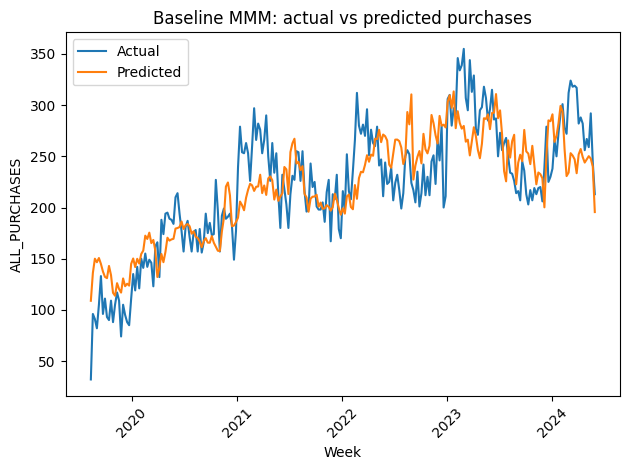

In [10]:
y_hat = model.predict(X)

plt.figure()
plt.plot(df_weekly["week"], y, label="Actual")
plt.plot(df_weekly["week"], y_hat, label="Predicted")
plt.title("Baseline MMM: actual vs predicted purchases")
plt.xlabel("Week")
plt.ylabel(target_col)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


## Inspect baseline coefficients
### Context
Before adding more complex effects, we inspect the magnitude and sign of the
baseline coefficients to identify potential issues such as extreme values
or negative relationships.


In [11]:
(coefs / coefs.abs().sum()).sort_values(ascending=False)


GOOGLE_SHOPPING_SPEND       0.315611
GOOGLE_PAID_SEARCH_SPEND    0.300263
GOOGLE_PMAX_SPEND           0.256422
GOOGLE_DISPLAY_SPEND        0.127704
GOOGLE_VIDEO_SPEND          0.000000
META_FACEBOOK_SPEND         0.000000
META_INSTAGRAM_SPEND        0.000000
META_OTHER_SPEND            0.000000
TIKTOK_SPEND                0.000000
dtype: float64

In [14]:
df_weekly.to_csv("../data/processed/mmm_dataset_weekly.csv",index="false")

### Decision
Do not interpret baseline coefficients as incremental or causal effects.
### Rationale
Without carryover, saturation, and proper controls, baseline coefficients
reflect correlations and structural biases rather than true channel impact.


## Why start with a linear regression baseline?

### Conceptual motivation

At its core, Marketing Mix Modeling (MMM) aims to explain how changes in marketing
inputs relate to changes in a business outcome over time.

Formally, the problem can be expressed as:

$y_t = f(x_{1,t}, x_{2,t}, \dots, x_{k,t}) + \varepsilon_t$

where:
- $y_t$ is the target KPI at time $t$
- $ x_{k,t} $ represents marketing spend for channel $ k $ at time $ t $
- $ \varepsilon_t $ captures unexplained variation

The simplest possible approximation of the unknown function $ f(\cdot) $ is a
linear function:

$y_t = \beta_0 + \sum_{k=1}^{K} \beta_k x_{k,t} + \varepsilon_t$

This formulation corresponds to an ordinary least squares (OLS) linear regression.

---

### Why a linear model is a useful starting point

Starting with a linear regression provides several advantages:

- **Transparency**: coefficients have a clear and interpretable meaning.
- **Debuggability**: modeling issues (e.g. dominance of search, zero coefficients)
  are visible rather than hidden.
- **Baseline comparison**: it establishes a reference point against which more
  complex models can be evaluated.

Importantly, this baseline is **not expected to be realistic**, but to be
**diagnostic**.

---

### Known limitations of the linear baseline

The linear model makes several strong assumptions that are known to be violated in
real-world marketing systems:

1. **Instantaneous effects**  
   The model assumes that spend at time $ t $ affects the KPI only at time $ t $.

2. **No diminishing returns**  
   The relationship between spend and outcome is assumed to be linear, implying
   constant marginal returns.

3. **No temporal dynamics**  
   Delayed effects, memory, and decay are ignored.

4. **Correlation, not causation**  
   Coefficients capture conditional associations in observational data, not causal
   effects.

As a result, upper-funnel channels often appear ineffective, while lower-funnel
channels (e.g. Search) dominate the attribution.

---

### Linear regression as a foundation for MMM

Despite these limitations, linear regression remains the backbone of many MMM
implementations.

More realistic MMMs extend the linear formulation by applying transformations to the
inputs:

$y_t = \beta_0 + \sum_{k=1}^{K} \beta_k \cdot g(\text{adstock}(x_{k,t})) + \varepsilon_t$


where:
- **Adstock** models carryover effects over time
- **$ g(\cdot) $** models diminishing returns (saturation)

After these transformations, the model remains linear in the coefficients
$ \beta_k $, preserving interpretability while capturing key marketing dynamics.

---

### Modeling philosophy

The purpose of starting with a linear baseline is not to obtain accurate attribution,
but to **expose what is missing**.

Understanding the failures of the baseline model provides the motivation for
introducing:
- carryover effects (adstock),
- diminishing returns (saturation),
- and additional controls.

In this sense, complexity is added **incrementally and deliberately**, rather than
all at once.
